In [78]:
from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
#from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

import pandas as pd
import torch
from tqdm import tqdm, trange
import numpy as np
import csv


# Importing specific libraries for data prerpcessing, model archtecture choice, training and evaluation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW

In [79]:
def labeliser_tweet(df, nb_tweets=5, random_state=0):
    
    # Vérifier si le fichier "label.csv" existe et charger les tweet_id déjà labelisés
    tweets_labelises = set()
    try:
        with open('label.csv', mode='r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                tweets_labelises.add(row['tweet_id'])
    except FileNotFoundError:
        pass
    
    # Sélectionner un échantillon aléatoire de tweets non encore labelisés
    df_a_labeliser = df[~df.index.isin(tweets_labelises)].sample(n=nb_tweets, random_state=random_state)
    
    # Labeliser les tweets sélectionnés et enregistrer les labels dans un fichier CSV
    with open('label.csv', mode='a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        if f.tell() == 0:
            writer.writerow(['tweet_id', 'text', 'label'])
        for tweet_id, text in df_a_labeliser['text'].items():
            label = input(f'Label pour le tweet suivant :\n{text}\n')
            # Écrire les données labelisées dans le fichier CSV
            writer.writerow([tweet_id, text, label])


In [21]:
df = pd.read_csv('data/data_concat_clean/base_annotation_fev23.csv', index_col='tweet_id').drop('Unnamed: 0', axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'data/data_concat_clean/base_annotation_fev23.csv'

In [12]:
labeliser_tweet(df, nb_tweets=50, random_state = 9)

Label pour le tweet suivant :
Affaire #AdèleHaenel : le réalisateur #ChristopheRuggia placé en garde à vue #MeToo https://t.co/6daXmWhTqK
1
Label pour le tweet suivant :
Un pain au chocolat peut-il permettre de se faire pardonner une agression sexuelle? #Haziza #balancetonporc https://t.co/g8YGxBzeJM
2
Label pour le tweet suivant :
@CordaniOfficiel Comme je vous comprends....j'ai le même problème avec le mois de février....courage #MeToo #MeTooInceste #metoosuisse #suisse #inceste #silence #maltraitance
2
Label pour le tweet suivant :
Publication livre : "Ni pantins ni soumis" ou les excès du #METOO  https://t.co/B0YvW5GyXA @libgallimard https://t.co/PcE29MWuPs
1
Label pour le tweet suivant :
*ⒸⒸ➥ #Venezuela ☛ Communist psychopaths | https://t.co/iFKJd7x2Kb | #Residente #RenéPérez #UnicefComunista #Unicef #JairBolsonaro #FernandoAlbán #Brasil #BrieLarson #BenicioDelToro #MeToo #AngelinaJolie #ACNUR #CateBlanchett #LGBT #Comunismo #Anticomunismo https://t.co/XmQppraaNU
0
Label pour le t

In [22]:
df_label = pd.read_csv('label.csv')

In [23]:
df_label.label.value_counts()

label
2.0    828
1.0    270
3.0    113
0.0     42
Name: count, dtype: int64

In [24]:
df_label = df_label.dropna()

In [25]:
# Defining constants
epochs = 10
MAX_LEN = 300
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

In [7]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=4)
model.to(device)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weig

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [8]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=10e-8)

/opt/mamba/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
text = df_label['text'].to_list()
labels = df_label['label'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [77]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.4, stratify = labels)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [11]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [12]:
train_loss_set=[]
for _ in trange(epochs, desc="Epoch"):  
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels.long())
        loss = outputs[0]
        train_loss_set.append(loss.item())    
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs =  model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels.long())
            loss, logits = outputs[:2]
    
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.2618875404198964


Epoch:  10%|█         | 1/10 [11:58<1:47:46, 718.47s/it]

Validation Accuracy: 0.683666087962963
Train loss: 1.0668712556362152


Epoch:  20%|██        | 2/10 [26:31<1:47:53, 809.18s/it]

Validation Accuracy: 0.683666087962963
Train loss: 0.957703024148941


Epoch:  30%|███       | 3/10 [41:12<1:38:15, 842.14s/it]

Validation Accuracy: 0.683666087962963
Train loss: 0.8441829631725947


Epoch:  40%|████      | 4/10 [56:13<1:26:33, 865.51s/it]

Validation Accuracy: 0.7936197916666666
Train loss: 0.7229040463765463


Epoch:  50%|█████     | 5/10 [1:11:12<1:13:06, 877.36s/it]

Validation Accuracy: 0.7316261574074074
Train loss: 0.6163275490204493


Epoch:  60%|██████    | 6/10 [1:25:21<57:51, 867.90s/it]  

Validation Accuracy: 0.7779947916666666
Train loss: 0.5189388146003088


Epoch:  70%|███████   | 7/10 [1:38:30<42:06, 842.19s/it]

Validation Accuracy: 0.8236400462962963
Train loss: 0.4161665042241414


Epoch:  80%|████████  | 8/10 [1:46:59<24:32, 736.00s/it]

Validation Accuracy: 0.8298611111111112
Train loss: 0.3496982256571452


Epoch:  90%|█████████ | 9/10 [1:54:01<10:37, 637.84s/it]

Validation Accuracy: 0.8383969907407407
Train loss: 0.2971478613714377


Epoch: 100%|██████████| 10/10 [2:00:39<00:00, 723.93s/it]

Validation Accuracy: 0.8423032407407407


In [55]:
def predict(model, dataloader):
    # mettre le modèle en mode d'évaluation
    model.eval()
    
    # stocker les prédictions de tous les batchs dans une liste
    predictions = []
    
    # boucle sur les batches dans le dataloader de test
    for batch in dataloader:
        
        # déplacer les données sur le même dispositif que le modèle
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # désactiver le calcul des gradients pour économiser de la mémoire et accélérer les calculs
        with torch.no_grad():
            # faire passer les données à travers le modèle pour obtenir les logits
            outputs =  model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
    
        # appliquer la fonction softmax pour obtenir les probabilités pour chaque classe
        probs = F.softmax(logits, dim=-1)
        
        # convertir les probabilités en prédictions en prenant l'indice de la classe avec la probabilité la plus élevée
        batch_preds = torch.argmax(probs, dim=1)
        
        # ajouter les prédictions pour ce batch à la liste de prédictions globale
        predictions.extend(batch_preds.cpu().numpy().tolist())
    
    # retourner la liste de prédictions globale
    return predictions


In [58]:
predictions_val = predict(model, validation_dataloader)


KeyboardInterrupt: 

In [70]:
unique, counts = np.unique(validation_labels.numpy(), return_counts=True)
label_counts = dict(zip(unique, counts))
print(label_counts)

{0.0: 17, 1.0: 100, 2.0: 343, 3.0: 42}


In [60]:
cm = confusion_matrix(validation_labels, predictions)

In [71]:
cm_df = pd.DataFrame(cm,
                     index = ['Autre','Presse','Opinion','Témoignage'], 
                     columns = ['Autre','Presse','Opinion','Témoignage'])

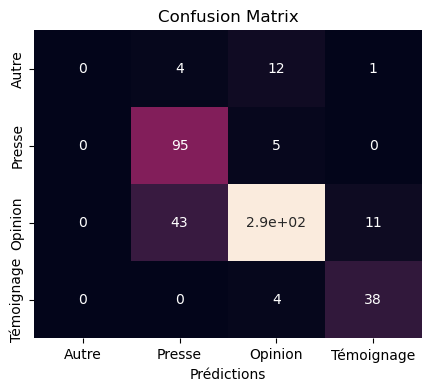

In [76]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cbar = False)
plt.title('Confusion Matrix')
plt.ylabel('')
plt.xlabel('Prédictions')
plt.show()